## 01c POI Data - Preprocessing

In [1]:
#Imports
import osmnx as ox
import folium
import geopandas as gp

from shapely.geometry import Point, Polygon
from h3 import h3 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# POIs in OSM are called amenities
amenity_pois = ox.features_from_place({'city': 'Chicago'}, {'amenity': True})
amenity_pois.head(3)

amenity ferry  \
element_type osmid                               
node         20217109     ferry_terminal   yes   
             20217442     ferry_terminal   yes   
             269449042  parking_entrance   NaN   

                                                                     name  \
element_type osmid                                                          
node         20217109                               Shoreline Sightseeing   
             20217442   Union Station/Willis Tower - Shoreline Water T...   
             269449042                                                NaN   

                                     network              operator  \
element_type osmid                                                   
node         20217109   Shoreline Water Taxi  Shoreline Water Taxi   
             20217442   Shoreline Water Taxi  Shoreline Water Taxi   
             269449042                   NaN                   NaN   

                       public_transport source                    geometry  \
element_type osmid                                                           
node         20217109           station    PGS  POINT (-87.62252 41.88914)   
             20217442           station    NaN  POINT (-87.63774 41.87906)   
             269449042              NaN    NaN  POINT (-87.61506 41.85869)   

                       highway access  ... building:min_level marketplace  \
element_type osmid                     ...                                  
node         20217109      NaN    NaN  ...                NaN         NaN   
             20217442      NaN    NaN  ...                NaN         NaN   
             269449042     NaN    NaN  ...                NaN         NaN   

                       ways name:fa name:fr name:tl not:name industrial  \
element_type osmid                                                        
node         20217109   NaN     NaN     NaN     NaN      NaN        NaN   
             20217442   NaN     NaN     NaN     NaN      NaN        NaN   
             269449042  NaN     NaN     NaN     NaN      NaN        NaN   

                       diet:dairy_free waterway  
element_type osmid                               
node         20217109              NaN      NaN  
             20217442              NaN      NaN  
             269449042             NaN      NaN  

[3 rows x 534 columns]

In [3]:
# Next to amenities is an extra section for public transport, we could also use this in addition:
# https://wiki.openstreetmap.org/wiki/Map_features#Addresses
transport_pois = ox.features_from_place({'city': 'Chicago'}, {'public_transport': True})

In [4]:
# Pick fields of interest, drop unnecessary column "element_type" and reset index
amenity_pois = amenity_pois[["amenity", "name", "geometry", "public_transport"]].reset_index().set_index("osmid").drop("element_type", axis=1)
amenity_pois.head(3)

,amenity,name,geometry,public_transport
osmid,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station
269449042,parking_entrance,NaN,POINT (-87.61506 41.85869),NaN


In [5]:
# To geodf, check if right CRS for lat/lon later
amenity_gdf = gp.GeoDataFrame(amenity_pois)
# amenity_gdf = amenity_gdf.to_crs(4326)
print(amenity_gdf.crs)

epsg:4326


In [6]:
# Count how many unique entries there are, get overview
print(f"Unique amenities in Chicago: {len(amenity_gdf['amenity'].unique())}")

amenity_counts = amenity_gdf['amenity'].value_counts()
print("Amenities in Chicago and their count:")
for amenity, count in amenity_counts.items():
    print(f"{amenity}: {count}")

Unique amenities in Chicago: 126
Amenities in Chicago and their count:
parking: 7180
parking_space: 4989
restaurant: 2246
place_of_worship: 1862
fast_food: 1336
bicycle_parking: 1263
school: 1151
bench: 1009
bicycle_rental: 895
bar: 849
cafe: 757
parking_entrance: 480
bank: 454
fuel: 420
post_box: 294
loading_dock: 288
shelter: 287
toilets: 256
waste_basket: 227
social_facility: 226
fountain: 214
drinking_water: 207
pharmacy: 177
clinic: 170
vending_machine: 132
ice_cream: 119
library: 107
dentist: 103
fire_station: 103
atm: 103
pub: 98
post_office: 97
studio: 94
theatre: 88
car_wash: 70
community_centre: 63
charging_station: 59
university: 52
childcare: 50
doctors: 47
ferry_terminal: 45
arts_centre: 40
hospital: 40
police: 39
events_venue: 38
veterinary: 37
social_centre: 35
recycling: 30
money_transfer: 30
kindergarten: 28
college: 27
car_rental: 25
cinema: 24
bus_station: 22
bicycle_repair_station: 21
post_depot: 21
public_bookcase: 19
nightclub: 19
bureau_de_change: 19
taxi: 18
ani

In [7]:
# Add lat and lon for each entry (eometry column can also be a multipolygon)
amenity_gdf["latitude"] = amenity_gdf.geometry.apply(lambda row: row.y if isinstance(row, Point) else row.centroid.y)
amenity_gdf["longitude"] = amenity_gdf.geometry.apply(lambda row: row.x if isinstance(row, Point) else row.centroid.x)

In [8]:
# Add the count for each amenity type as column
amenity_gdf["count"] = amenity_gdf.groupby("amenity")['name'].transform('count')
amenity_gdf.head()

,amenity,name,geometry,public_transport,latitude,longitude,count
osmid,,,,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station,41.889145,-87.622517,45
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station,41.879062,-87.637740,45
269449042,parking_entrance,NaN,POINT (-87.61506 41.85869),NaN,41.858689,-87.615058,10
269450074,parking_entrance,NaN,POINT (-87.58420 41.79174),NaN,41.791742,-87.584197,10
269450344,parking_entrance,NaN,POINT (-87.61195 41.84968),NaN,41.849677,-87.611945,10


In [9]:
# Get hex ids
def hex_ids(df, res):
    df[f"h3_res{res}"] = df.apply(
        lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], res), axis=1)
    return amenity_gdf

# Get poly from hex ids
def poly_from_hex(df, res):
    df[f"poly_res{res}"] = df.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[f"h3_res{res}"], geo_json=True)), axis=1)
    return df

In [10]:
hex_df = hex_ids(amenity_gdf, 6)
hex_df = hex_ids(amenity_gdf, 7)
hex_df = hex_ids(amenity_gdf, 8)
hex_df = hex_ids(amenity_gdf, 9)

hex_df = poly_from_hex(hex_df, 6)
hex_df = poly_from_hex(hex_df, 7)
hex_df = poly_from_hex(hex_df, 8)
hex_df = poly_from_hex(hex_df, 9)

hex_df.head()

,amenity,name,geometry,public_transport,latitude,longitude,count,h3_res6,h3_res7,h3_res8,h3_res9,poly_res6,poly_res7,poly_res8,poly_res9
osmid,,,,,,,,,,,,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station,41.889145,-87.622517,45,862664c1fffffff,872664c1effffff,882664c1e3fffff,892664c1e23ffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899...","POLYGON ((-87.63049 41.90755, -87.64322 41.899...","POLYGON ((-87.62100 41.89255, -87.62704 41.890...","POLYGON ((-87.62224 41.88964, -87.62405 41.888..."
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station,41.879062,-87.637740,45,862664c1fffffff,872664c1affffff,882664c1adfffff,892664c1ac7ffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899...","POLYGON ((-87.63912 41.88714, -87.65185 41.878...","POLYGON ((-87.63912 41.88714, -87.64516 41.885...","POLYGON ((-87.63737 41.88193, -87.63919 41.880..."
269449042,parking_entrance,NaN,POINT (-87.61506 41.85869),NaN,41.858689,-87.615058,10,862664c1fffffff,872664c1bffffff,882664c1b1fffff,892664c1b03ffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899...","POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.61347 41.86360, -87.61951 41.861...","POLYGON ((-87.61470 41.86069, -87.61652 41.859..."
269450074,parking_entrance,NaN,POINT (-87.58420 41.79174),NaN,41.791742,-87.584197,10,862664cc7ffffff,872664cc5ffffff,882664cc59fffff,892664cc583ffff,"POLYGON ((-87.61458 41.81426, -87.65679 41.801...","POLYGON ((-87.59371 41.79823, -87.60642 41.789...","POLYGON ((-87.58230 41.79718, -87.58833 41.795...","POLYGON ((-87.58353 41.79427, -87.58535 41.793..."
269450344,parking_entrance,NaN,POINT (-87.61195 41.84968),NaN,41.849677,-87.611945,10,862664c1fffffff,872664c1bffffff,882664c1b3fffff,892664c1b2fffff,"POLYGON ((-87.60092 41.91193, -87.64322 41.899...","POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.60873 41.85610, -87.61477 41.854...","POLYGON ((-87.61120 41.85027, -87.61302 41.849..."


In [11]:
def make_geodfs(res):
    return gp.GeoDataFrame(hex_df, geometry=hex_df[f'poly_res{res}'], crs='EPSG:4326')

gdf_res6 = make_geodfs(6)
gdf_res7 = make_geodfs(7)
gdf_res8 = make_geodfs(8)
gdf_res9 = make_geodfs(9)

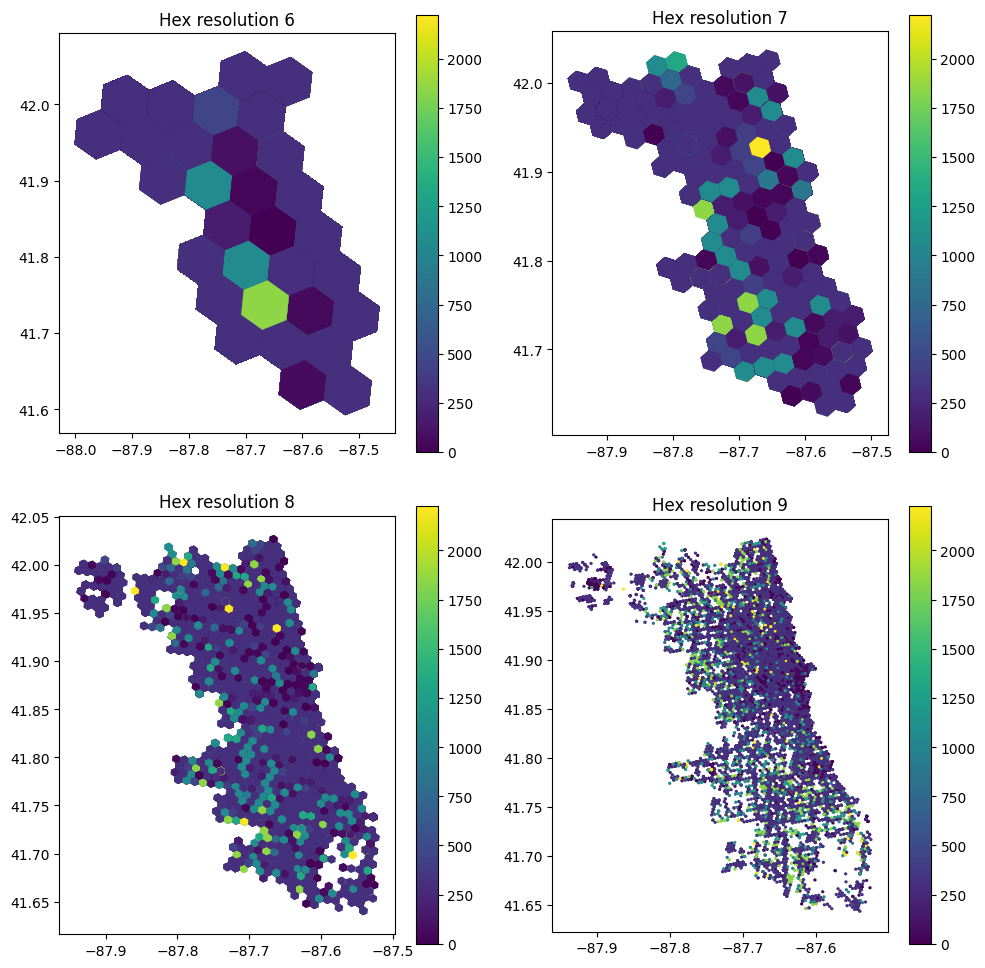

In [12]:
# Visualize the amenities with different hex resolutions, TODO: decide which fits best/compare with taxidata
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))
dfs = [gdf_res6, gdf_res7 , gdf_res8, gdf_res9]

titles = ["Hex resolution 6", "Hex resolution 7", "Hex resolution 8", "Hex resolution 9"]

axs = axs.flatten()
for ind in range(0, 4):
    dfs[ind].plot(column="count", ax=axs[ind], legend=True)
    axs[ind].set_title(titles[ind])

plt.tight_layout()
plt.show()

As we can tell from the graphic, it is better to focus on a more granular view. Just like we did with the main taxi dataframe, we will only consider the hex resolution 7 as well as 8 for further tasks.

In [13]:
poi_df = hex_df.drop(['h3_res6',  'h3_res9', 'poly_res6','poly_res9'], axis=1)
poi_df.columns

Index(['amenity', 'name', 'geometry', 'public_transport', 'latitude',
       'longitude', 'count', 'h3_res7', 'h3_res8', 'poly_res7', 'poly_res8'],
      dtype='object')

In [14]:
# Get density (how many amenities there are in a hexagon)
poi_df['poi_density_res7'] = poi_df.groupby('h3_res7')['h3_res7'].transform('count')
poi_df['poi_density_res8'] = poi_df.groupby('h3_res8')['h3_res8'].transform('count')
poi_df

,amenity,name,geometry,public_transport,latitude,longitude,count,h3_res7,h3_res8,poly_res7,poly_res8,poi_density_res7,poi_density_res8
osmid,,,,,,,,,,,,,
20217109,ferry_terminal,Shoreline Sightseeing,POINT (-87.62252 41.88914),station,41.889145,-87.622517,45,872664c1effffff,882664c1e3fffff,"POLYGON ((-87.63049 41.90755, -87.64322 41.899...","POLYGON ((-87.62100 41.89255, -87.62704 41.890...",1621,328
20217442,ferry_terminal,Union Station/Willis Tower - Shoreline Water T...,POINT (-87.63774 41.87906),station,41.879062,-87.637740,45,872664c1affffff,882664c1adfffff,"POLYGON ((-87.63912 41.88714, -87.65185 41.878...","POLYGON ((-87.63912 41.88714, -87.64516 41.885...",1822,417
269449042,parking_entrance,NaN,POINT (-87.61506 41.85869),NaN,41.858689,-87.615058,10,872664c1bffffff,882664c1b1fffff,"POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.61347 41.86360, -87.61951 41.861...",349,36
269450074,parking_entrance,NaN,POINT (-87.58420 41.79174),NaN,41.791742,-87.584197,10,872664cc5ffffff,882664cc59fffff,"POLYGON ((-87.59371 41.79823, -87.60642 41.789...","POLYGON ((-87.58230 41.79718, -87.58833 41.795...",385,47
269450344,parking_entrance,NaN,POINT (-87.61195 41.84968),NaN,41.849677,-87.611945,10,872664c1bffffff,882664c1b3fffff,"POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.60873 41.85610, -87.61477 41.854...",349,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17771252,parking,NaN,"POLYGON ((-87.61337 41.86172, -87.61340 41.861...",NaN,41.862827,-87.613215,305,872664c1bffffff,882664c1b1fffff,"POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.61347 41.86360, -87.61951 41.861...",349,36
17771256,parking,NaN,"MULTIPOLYGON (((-87.61294 41.85874, -87.61304 ...",NaN,41.859387,-87.612991,305,872664c1bffffff,882664c1b1fffff,"POLYGON ((-87.61821 41.87110, -87.63093 41.862...","POLYGON ((-87.61347 41.86360, -87.61951 41.861...",349,36
17778935,parking,31st Street Harbor Parking,"POLYGON ((-87.60565 41.83572, -87.60541 41.835...",NaN,41.835339,-87.605556,305,872664ce6ffffff,882664ce67fffff,"POLYGON ((-87.59731 41.85506, -87.61003 41.846...","POLYGON ((-87.59926 41.84111, -87.60530 41.839...",11,4


In [15]:
# Map the categories to have a better understanding
category_mapping = {
    'Transportation': ['parking', 'parking_space', 'bicycle_parking', 'bicycle_rental', 'parking_entrance', 'car_rental', 'bus_station', 'ferry_terminal', 'taxi', 'car_sharing', 'motorcycle_parking', 'boat_rental'],
    'Food and Drink': ['restaurant', 'fast_food', 'bar', 'cafe', 'ice_cream', 'pub', 'food_court', 'biergarten'],
    'Education': ['school', 'university', 'library', 'college', 'kindergarten', 'music_school', 'language_school', 'driving_school', 'prep_school', 'research_institute'],
    'Healthcare': ['pharmacy', 'clinic', 'dentist', 'doctors', 'hospital', 'veterinary', 'nursing_home', 'mortuary'],
    'Recreation and Entertainment': ['bench', 'fountain', 'theatre', 'arts_centre', 'events_venue', 'cinema', 'nightclub', 'stripclub', 'casino', 'internet_cafe'],
    'Financial Services': ['bank', 'atm', 'bureau_de_change', 'money_transfer', 'payment_terminal', 'payment_centre'],
    'Public Services': ['post_box', 'post_office', 'fire_station', 'police', 'courthouse', 'prison', 'townhall', 'ranger_station'],
    'Religious and Community': ['place_of_worship', 'social_facility', 'community_centre', 'social_centre', 'monastery', 'fraternity'],
    'Shopping and Retail': ['vending_machine', 'marketplace', 'books', 'freeshop'],
    'Accommodation': ['shelter'],
    'Utilities': ['fuel', 'charging_station', 'waste_disposal', 'recycling', 'device_charging_station', 'pumping_station','car_wash', 'waste_transfer_station'],
    'Sports and Fitness': ['dojo', 'training',],
    'Personal Care': ['toilets', 'shower', 'public_bath'],
    'Animal Services': ['animal_boarding', 'animal_shelter', 'dog daycare and boarding', 'dog_toilet'],
}

amenity_to_category = {}
for category, amenities in category_mapping.items():
    for amenity in amenities:
        amenity_to_category[amenity] = category

def get_category(amenity):
    return amenity_to_category.get(amenity, 'Miscellaneous')

# Miscellaneous categories that do not fit very well
poi_df['category'] = poi_df['amenity'].apply(get_category)
poi_df[poi_df["category"] == "Miscellaneous"]["amenity"].unique()

array(['loading_dock', 'drinking_water', 'clock', 'grave_yard', 'vacant',
       'studio', 'waste_basket', 'locker', 'bicycle_repair_station',
       'childcare', 'photo_booth', 'grit_bin', 'public_bookcase',
       'binoculars', 'parcel_locker', 'compressed_air', 'vacuum_cleaner',
       'weighbridge', 'give_box', 'watering_place', 'fast_food;ice_cream',
       'tool_library', 'letter_box', 'table', 'fixme', 'library_dropoff',
       'Junk Removal Chicago', 'post_depot', 'planetarium',
       'flight_school', 'dressing_room', 'lifeguard', 'conference_centre',
       'construction', 'boat_storage', 'vehicle_inspection'], dtype=object)

In [16]:
poi_df.isna().sum()

amenity                 0
name                16777
geometry                0
public_transport    29387
latitude                0
longitude               0
count                   0
h3_res7                 0
h3_res8                 0
poly_res7               0
poly_res8               0
poi_density_res7        0
poi_density_res8        0
category                0
dtype: int64

In [19]:
# Drop poly cols since can add at any time + be able to save as geojson
poi_df = poi_df.drop(["poly_res7", "poly_res8"], axis=1)

In [20]:
poi_df.to_file('data/prepped/poi_df.geojson', driver = 'GeoJSON')